In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import sys 
sys.path.append('../')
env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
%matplotlib inline

In [2]:
from wompth.models.dqn import Transition, ReplayMemory, DQN, ScreenDims, DQNConf, fit_networks

/home/gorigan/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


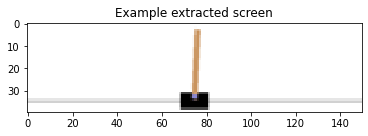

In [3]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width)
    slice_range = slice(view_width)
#     cart_location = get_cart_location(screen_width)
#     if cart_location < view_width // 2:
#         slice_range = slice(view_width)
#     elif cart_location > (screen_width - view_width // 2):
#         slice_range = slice(-view_width, None)
#     else:
#         slice_range = slice(cart_location - view_width // 2,
#                             cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [4]:
get_screen().cpu().squeeze(0).shape

torch.Size([3, 40, 150])

In [5]:

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n
screen_dims = ScreenDims(screen_height, screen_width)


In [6]:
# nn.Sequential(
#     nn.Conv2d(3,32,kernel_size=3,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
#     nn.ReLU(),
#     nn.MaxPool2d(2,2),

#     nn.Flatten(),
#     nn.Linear(256*4*4,1024),
#     nn.ReLU(),
#     nn.Linear(1024,512),
#     nn.ReLU(),
#     nn.Linear(512,10))

In [ ]:
# sequential = nn.Sequential(
#       nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2),
#       nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
#       nn.ReLU(),
#       nn.MaxPool2d(kernel_size=2, stride=2),
#       nn.Flatten(start_dim=1)  ,
#       nn.Linear(in_features=15232, out_features=120),
#       nn.ReLU(),
#       nn.Linear(in_features=120, out_features=60),
#       nn.ReLU(),
#       nn.Linear(in_features=60, out_features=2)
# )

In [ ]:
# sequential(get_screen())

In [9]:
get_screen().shape

torch.Size([1, 3, 40, 150])

In [25]:
from functools import partial
class DQN_BackBone(DQN): 
    def __init__(
        self,
        device="cuda",
        conf: DQNConf = DQNConf(),
        optimizer_partial=partial(optim.RMSprop),
        memory=ReplayMemory(10000),
        outputs=2
    ):
        super().__init__(device, conf, optimizer_partial, memory, outputs)

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)        
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(150)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(40)))
        linear_input_size = convw * convh * 32
        
        self.fc1 = nn.Linear(in_features=linear_input_size, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=self._outputs)
        self._send_to_device(device=device)

        
    def forward(self, x):
        x = x.to(self._device)
       
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.out(x)

        return x
        

In [26]:
conf = DQNConf(
    BATCH_SIZE = 128,
    GAMMA = 0.999,
    EPS_START = 0.5,
    TARGET_UPDATE = 10, 
    MAX_EPISODES = 2000
)

In [27]:
target_net = DQN_BackBone(conf=conf)

Using cuda device


In [28]:
target_net(get_screen())

tensor([[-0.0229,  0.2476]], device='cuda:0', grad_fn=<AddmmBackward>)

In [29]:
# target_net._linear_input_size, target_net._epsilon

In [30]:

# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()


def moving_average_pth(x, w=10):
    kernel = [1/w] * w
    ts_tensor = torch.Tensor(x).reshape(1, 1, -1)
    kernel_tensor = torch.Tensor(kernel).reshape(1, 1, -1)
    return F.conv1d(ts_tensor, kernel_tensor).reshape(-1)

def plot_durations(i_episode, episode_durations):
    display.clear_output(wait=True)

    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel(f'Episode {i_episode}')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    means = moving_average_pth(durations_t, conf.TARGET_UPDATE)
    plt.plot(means.numpy())
    display.display(plt.gcf())


In [31]:
def reward_function_step(done, t, step_reward=10, max_reward=200):
    reward = 0

    if done:
        if t >= max_reward:
            reward = t  # discounted steps
        else: 
            reward = -(max_reward - t)
    elif t >= step_reward: 
        step_bonus = ((t // step_reward)+1)*10
        reward = step_bonus + t # promote the reward in steps 
    else: 
        reward = t

    return reward 
for t in range(0, 220, 10):
    print (t, reward_function_step(False, t), reward_function_step(True, t),) 

0 0 -200
10 30 -190
20 50 -180
30 70 -170
40 90 -160
50 110 -150
60 130 -140
70 150 -130
80 170 -120
90 190 -110
100 210 -100
110 230 -90
120 250 -80
130 270 -70
140 290 -60
150 310 -50
160 330 -40
170 350 -30
180 370 -20
190 390 -10
200 410 200
210 430 210


In [32]:
def reward_function_linear(done, t, max_reward=200):
    reward = 0

    if done:
        if t >= max_reward:
            reward = t  # discounted steps
        else: 
            reward = -(max_reward - t)
    else:
        reward = t

    return reward 
for t in range(0, 220, 10):
    print (t, reward_function_linear(False, t), reward_function_linear(True, t),) 

0 0 -200
10 10 -190
20 20 -180
30 30 -170
40 40 -160
50 50 -150
60 60 -140
70 70 -130
80 80 -120
90 90 -110
100 100 -100
110 110 -90
120 120 -80
130 130 -70
140 140 -60
150 150 -50
160 160 -40
170 170 -30
180 180 -20
190 190 -10
200 200 200
210 210 210


In [33]:
def reward_function_linear2(done, t, max_reward=200):
    reward = 0

    if done:
        if t >= (max_reward /2) :
            reward = t  # discounted steps
        else:             
            reward = -(max_reward - t)
    else:
        reward = t

    return reward 
for t in range(0, 220, 10):
    print (t, reward_function_linear2(False, t), reward_function_linear2(True, t),) 

0 0 -200
10 10 -190
20 20 -180
30 30 -170
40 40 -160
50 50 -150
60 60 -140
70 70 -130
80 80 -120
90 90 -110
100 100 100
110 110 110
120 120 120
130 130 130
140 140 140
150 150 150
160 160 160
170 170 170
180 180 180
190 190 190
200 200 200
210 210 210


In [34]:
episode_durations = []

In [35]:
num_episodes = conf.MAX_EPISODES
# restart policy net
policy_net = DQN_BackBone(conf=conf)
policy_net.load_states_from(target_net)

durations = fit_networks(policy_net, target_net, env, get_screen, 
                             num_episodes=num_episodes, 
                             episode_durations=episode_durations)
print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

Using cuda device


KeyboardInterrupt: 

In [ ]:
moving_average_pth(episode_durations[:1000], 2).max()

In [ ]:
str(conf)

In [ ]:
target_net

In [ ]:
env.reset()
last_screen = get_screen()
current_screen = get_screen()
state = current_screen - last_screen
for t in count():
    # Select and perform an action
    action = policy_net.select_action(state)
    _, reward, done, _ = env.step(action.item())

    # Observe new state
    last_screen = current_screen
    current_screen = get_screen()
    if not done:
        next_state = current_screen - last_screen
    else:
        next_state = None
    
    state = next_state

    if done:
        episode_durations.append(t + 1)
        print(t)
        break